In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.models import Sequential, load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169, DenseNet121
from keras.applications.resnet import ResNet50

from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

sns.set(style='white', context='notebook', palette='deep')

In [6]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [7]:
def convert_to_ela_image(path, quality):
    filename = path
    n = 2
    name_arr = filename.split('.')
    resaved_filename = '.' + name_arr[n-1] + '.resaved.jpg'
   
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

### Sample: Real Image

Let's open a real (not-fake) image as a sample.

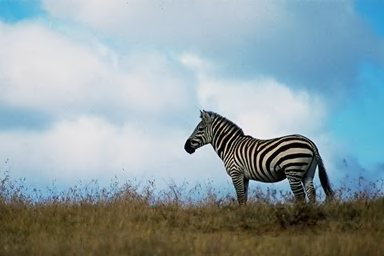

In [8]:
Image.open('./CASIA1/Au/Au_ani_0001.jpg')

This is how it looks like after it is processed with error-level analysis (ELA).

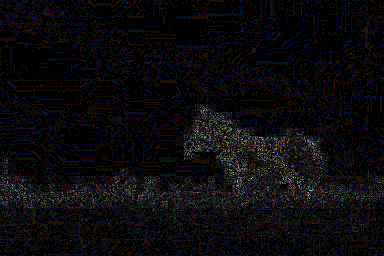

In [9]:
convert_to_ela_image("./CASIA1/Au/Au_ani_0001.jpg", 90)

### Sample: Fake Image

This is how it looks like after it has been edited.

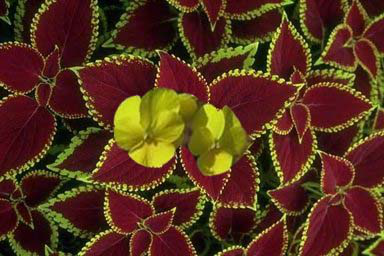

In [10]:
Image.open('./CASIA1/Sp/Sp_D_CND_A_pla0005_pla0023_0281.jpg')

This is the result of the fake image after getting through ELA. We can compare the difference between the picture below and the real picture's ELA result.

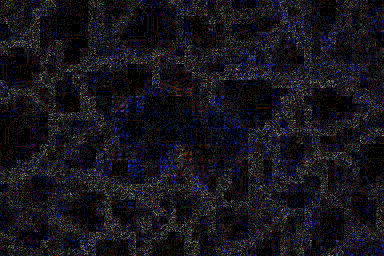

In [11]:
convert_to_ela_image('./CASIA1/Sp/Sp_D_CND_A_pla0005_pla0023_0281.jpg', 90)

## Data preparation

In [12]:
X = []
Y = []

In [13]:
for filename in os.listdir("./CASIA1/Au/"):
    X.append(array(convert_to_ela_image(os.path.join("./CASIA1/Au/", filename), 90).resize((128, 128))).flatten() / 255.0)
    Y.append(0)
    
for filename in os.listdir("./CASIA1/Sp/"):
    X.append(array(convert_to_ela_image(os.path.join("./CASIA1/Sp/", filename), 90).resize((128, 128))).flatten() / 255.0)
    Y.append(1)

### Normalization

In [14]:
X = np.array(X)
Y = to_categorical(Y, 2)

### Reshape X

In [15]:
X = X.reshape(-1, 128, 128, 3)

## Train-test split

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

## CNN building

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


In [ ]:
# def build_model():
#     base_model = VGG16(input_shape=(None, None,3),
#     weights='imagenet',
#     include_top=False,
#     pooling='avg')
#     # i = 0
#     # total_layers = len(base_model.layers)
#     # for layer in base_model.layers:
#     # if(i <= total_layers//2):
#     # layer.trainable = True
#     # i = i+1

#     x = base_model.output

#     # x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
#     # x = Activation('relu')(x)
#     # x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
#     # x = Activation('relu')(x)

#     predictions = Dense(2,activation='sigmoid')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)
#     return model

# model = build_model()

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               29491456  
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)              

### Add optimizer

In [ ]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)


In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


### Define early stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint('correct_model.h5', monitor='val_loss', save_best_only=True,verbose=1)

### Model training

In [ ]:
epochs = 30
batch_size = 20

In [ ]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
101/101 [==============================] - 121s 1s/step - loss: 0.3740 - accuracy: 0.8140 - val_loss: 0.4570 - val_accuracy: 0.7980

Epoch 00001: val_loss improved from inf to 0.45698, saving model to correct_model.h5
Epoch 2/30
101/101 [==============================] - 123s 1s/step - loss: 0.3467 - accuracy: 0.8274 - val_loss: 0.4090 - val_accuracy: 0.8040

Epoch 00002: val_loss improved from 0.45698 to 0.40902, saving model to correct_model.h5
Epoch 3/30
101/101 [==============================] - 128s 1s/step - loss: 0.3202 - accuracy: 0.8681 - val_loss: 0.8852 - val_accuracy: 0.7208

Epoch 00003: val_loss did not improve from 0.40902
Epoch 4/30
101/101 [==============================] - 125s 1s/step - loss: 0.2415 - accuracy: 0.9013 - val_loss: 0.4579 - val_accuracy: 0.8277

Epoch 00004: val_loss did not improve from 0.40902
Epoch 5/30
101/101 [==============================] - 134s 1s/step - loss: 0.1977 - accuracy: 0.9182 - val_loss: 0.3872 - val_accuracy: 0.8436

Epoc